# 楕円フーリエ変換・逆変換



In [1]:
import numpy as np
import matplotlib
# matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
from rdlib2 import *

import datetime
import time

import os

# 輪郭データからのひげ除去
def shaver(cnt):  # 輪郭点列のうち、ヒゲ要素を取り除く
    # まず輪郭列のスタート部分がヒゲ要素を取り除く
    while True:
        if len(cnt) > 2 and list(cnt[1][0])==list(cnt[-1][0]): # 最初の点がヒゲの先端
            cnt = cnt[1:-1]
        else:
            break
    # 途中のヒゲ要素を取り除く
    while True:
            l = len(cnt)
            for  i in range(1,len(cnt)-1):
                    if list(cnt[i-1][0]) == list(cnt[i+1][0]):
                            cnt = np.r_[cnt[:i],cnt[i+2:]]
            if l == len(cnt):
                break
    return cnt

# 輪郭に沿った長さ

        
# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度(0-359)
def getDegree(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0 :
            if dy == 0: # 例外
                deg = 0
            elif dy > 0:
                deg = 90
            else:
                deg = 270
        elif dx >0 and dy >= 0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        elif dx > 0 and dy < 0: 
            deg = 360+180*np.arctan(dy/dx)/np.pi
        else:
            deg =180*(1+ np.arctan(dy/dx)/np.pi)
            # deg = 270.0(1+np.arctan(dy/dx)/np.pi)
        return deg

In [2]:
kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'
nezumi='シルエット/17Inv_tri/17nezumi1o06_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
akumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
nezumiimg = getstandardShape(cv2.imread(nezumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  

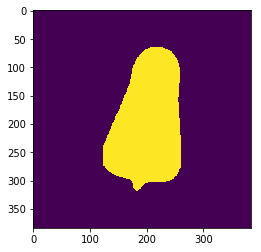

In [3]:
img = nezumiimg
plt.imshow(img)

(202.0, 198.0, (123, 65, 138, 253, 25059))

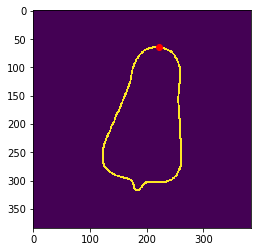

In [4]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[-10][0][0]],[cnt00[-10][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

# 楕円フーリエ記述子

## まず、経路長を横軸、X,Yを縦軸に取ったグラフ

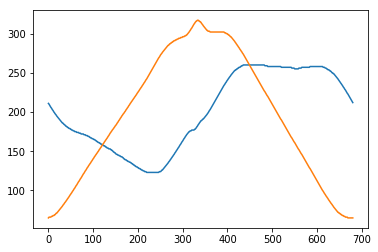

In [5]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

# サンプリング
点の数が多すぎるので、128点だけサンプリングしてみる

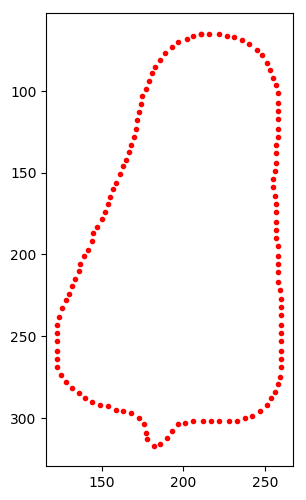

In [6]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True)
needLengs = np.linspace(0,allLength,SPANS) #  128分割した場合の弧距離のリスト
lengs.append(allLength)
cnt00 = np.r_[cnt00,[cnt00[0]]]
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)-1):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])

# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

サンプル点だけでX,Yをプロットして十分かどうか確認

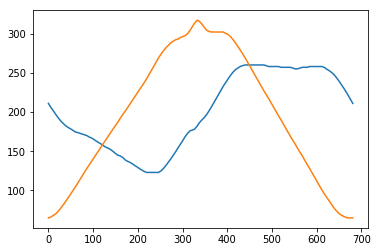

In [7]:
# 128点でプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

# フーリエ変換

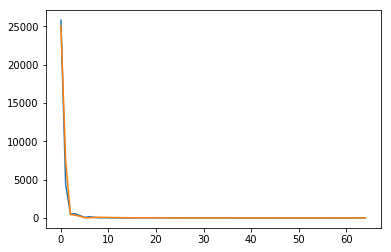

In [8]:
# フーリエ変換
Fx,Fy = np.fft.fft(samples[:,0]),np.fft.fft(samples[:,1])
# スペクトラム表示
Fx_abs = np.abs(Fx)
Fx_abs_amp = Fx_abs / SPANS *2 # 交流成分はデータ数で割って2倍
Fx_abs_amp[0] = Fx_abs_amp[0] / 2 # 直流成分は2倍不要

Fy_abs = np.abs(Fy)
Fy_abs_amp = Fy_abs / SPANS *2 # 交流成分はデータ数で割って2倍
Fy_abs_amp[0] = Fy_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0, int(SPANS/2), int(SPANS/2)+1)
plt.plot(fq, Fx_abs[:int(SPANS/2)+1])
plt.plot(fq, Fy_abs[:int(SPANS/2)+1])

# フーリエ逆変換

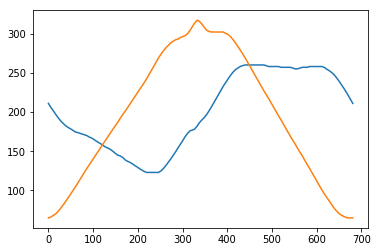

In [9]:
# フーリエ逆変換
Fx_ifft,Fy_ifft = np.fft.ifft(Fx), np.fft.ifft(Fy)
Fx_ifft_real,Fy_ifft_real  = Fx_ifft.real, Fy_ifft.real
plt.plot([lengs[i] for i in s_indexies],Fx_ifft_real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft_real)

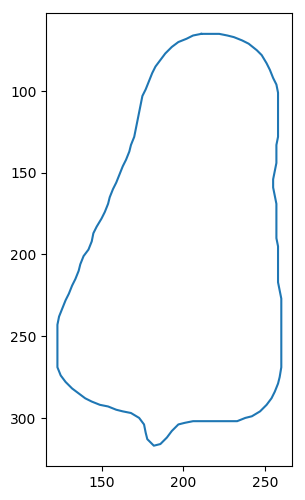

In [10]:
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft_real,Fy_ifft_real)

0j 0j


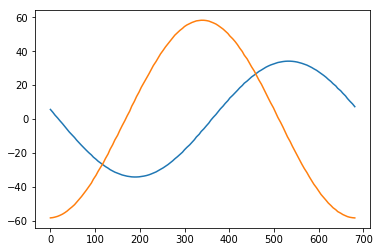

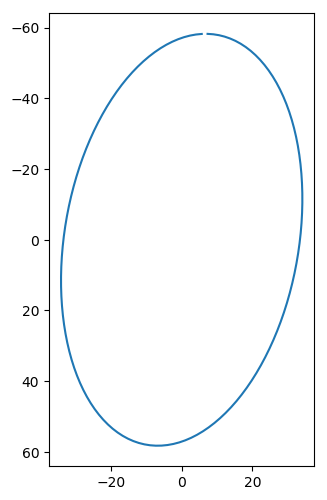

In [11]:
#  ローパスパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[2:]=0 # 3以降カット
Fy_cut[2:]=0
Fx_cut[0]=0 # 3以降カット
Fy_cut[0]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)
print(Fx_cut[0],Fx_cut[-1])

# Fx[1] と Fx[-1], Fy[1]とFy[-1]は複素共役の関係にある

In [12]:
print(Fx[0],Fy[0])
print(Fx[-1],Fy[-1])
print(Fx[1],Fy[1])
print(Fx[-2],Fy[-2])
print(Fx[2],Fy[2])

(25773+0j) (25011+0j)
(726.3049020991817-4309.977804941184j) (-7454.854323486934+242.6716242345551j)
(726.3049020991817+4309.977804941184j) (-7454.854323486934-242.6716242345551j)
(122.78908429408948+525.2822466988678j) (-343.0432547734389+297.20759623752735j)
(122.78908429408948-525.2822466988678j) (-343.0432547734389-297.20759623752735j)


#  ローパスフィルタ
高周波成分をカット



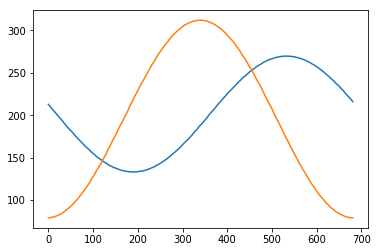

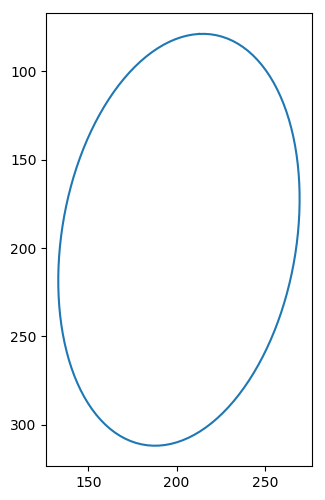

In [13]:
#  ローパスパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[2:-1]=0 # 2以降カット
Fy_cut[2:-1]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real) 

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

これは楕円近似にほかならない

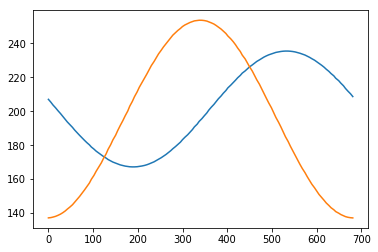

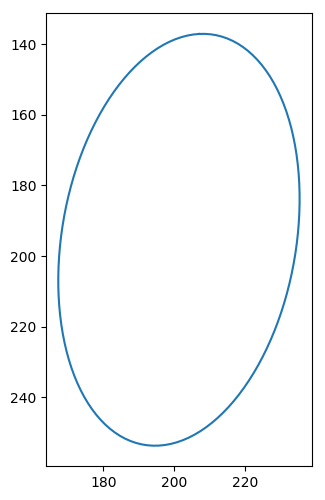

In [14]:
#  ローパスパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[2:]=0 # 2以降カット
Fy_cut[2:]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

楕円フーリエ変換の場合、real パートのみを使うなら、Fx[1] と Fx[-1]のうちの一方だけで復元しても両方使って復元しても結果は同じになる。

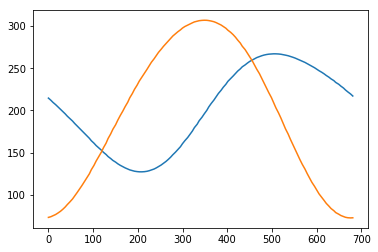

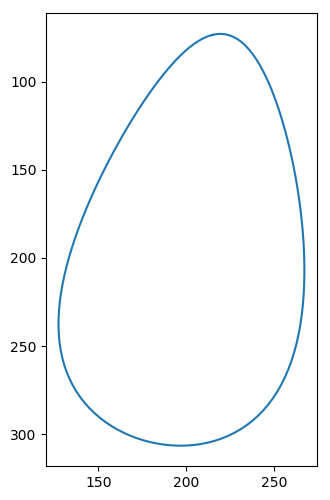

In [15]:
#  　ローパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[3:-2]=0 # 0,1,2のみ
Fy_cut[3:-2]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

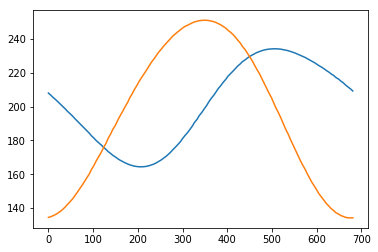

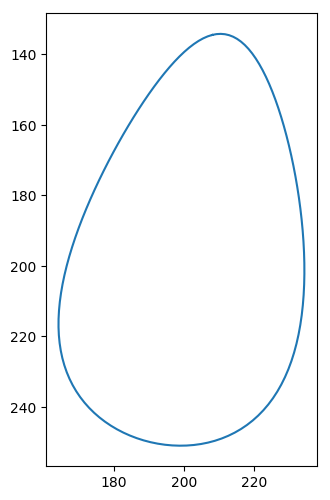

In [16]:
#  　ローパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[3:]=0 # 0,1,2のみ
Fy_cut[3:]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

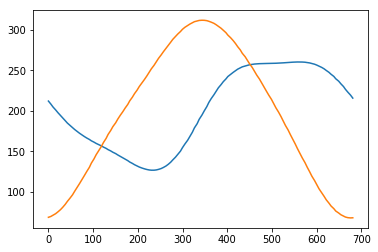

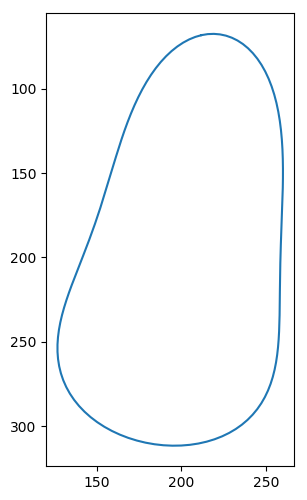

In [17]:
#  ハイパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[4:-3]=0 # 0,1,2,3   それ以降カット
Fy_cut[4:-3]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

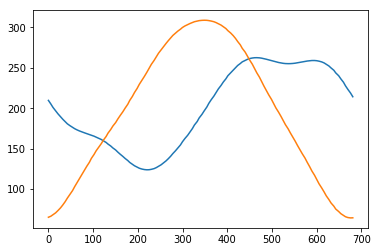

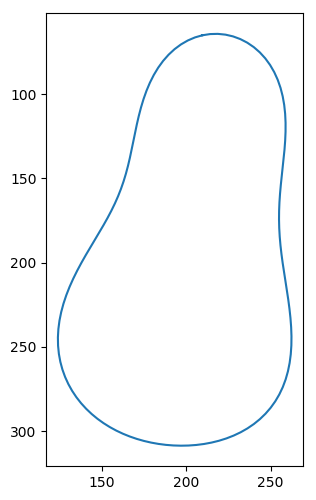

In [18]:
#  ハイパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[5:-4]=0 # 0,1,2,3,4   それ以降カット
Fy_cut[5:-4]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

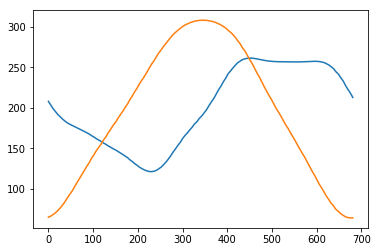

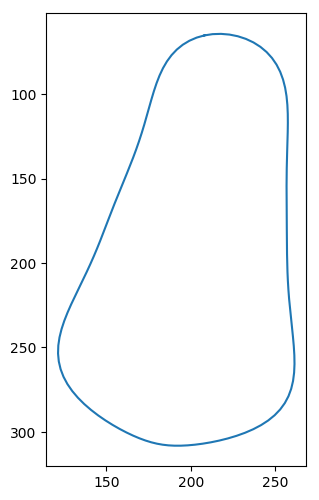

In [19]:
#  ハイパスフィルタを通してフーリエ逆変換
Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
Fx_cut[7:-6]=0 # 7以降カット
Fy_cut[7:-6]=0
Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
plt.plot([lengs[i] for i in s_indexies],Fx_ifft.real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft.real)

# 復元
Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft.real,Fy_ifft.real)

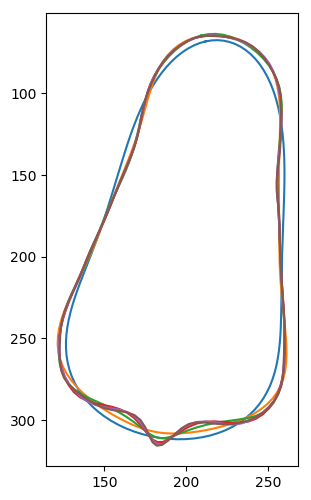

In [20]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
    Fx_cut[cutn:-cutn+1]=0 # 
    Fy_cut[cutn:-cutn+1]=0
    Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
    Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
    Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
    plt.plot(Fx_ifft.real,Fy_ifft.real)

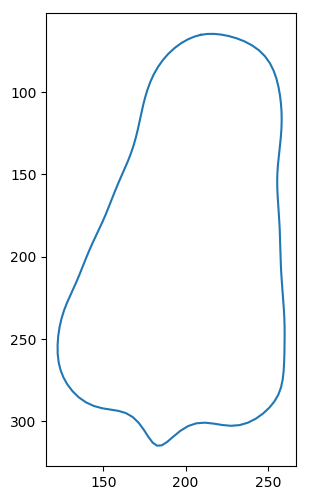

In [21]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(16,17):
    Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
    Fx_cut[cutn:1-cutn]=0 # 
    Fy_cut[cutn:1-cutn]=0
    Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
    Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
    Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
    plt.plot(Fx_ifft.real,Fy_ifft.real)

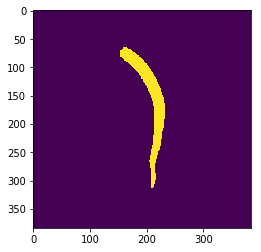

In [22]:
img = aomidaimg
plt.imshow(img)

(205.0, 162.0, (153, 66, 79, 249, 4474))

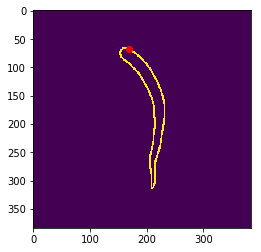

In [23]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[-10][0][0]],[cnt00[-10][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

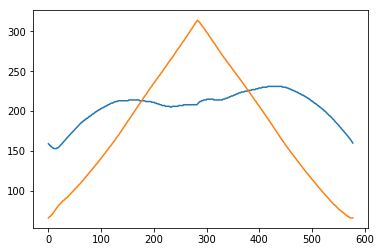

In [24]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

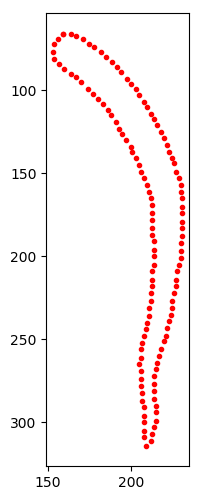

In [25]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True)
needLengs = np.linspace(0,allLength,SPANS) #  128分割した場合の弧距離のリスト
lengs.append(allLength)
cnt00 = np.r_[cnt00,[cnt00[0]]]
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)-1):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

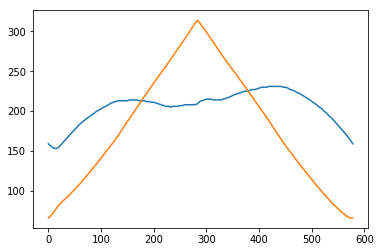

In [26]:
# 128点でX,Yを横軸を経路長としてプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

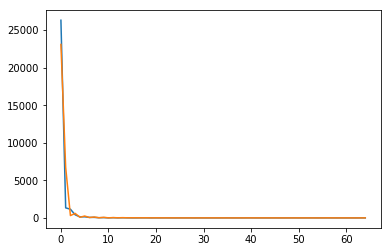

In [27]:
# フーリエ変換
Fx,Fy = np.fft.fft(samples[:,0]),np.fft.fft(samples[:,1])
# スペクトラム表示
Fx_abs = np.abs(Fx)
Fx_abs_amp = Fx_abs / SPANS *2 # 交流成分はデータ数で割って2倍
Fx_abs_amp[0] = Fx_abs_amp[0] / 2 # 直流成分は2倍不要

Fy_abs = np.abs(Fy)
Fy_abs_amp = Fy_abs / SPANS *2 # 交流成分はデータ数で割って2倍
Fy_abs_amp[0] = Fy_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0, int(SPANS/2), int(SPANS/2)+1)
plt.plot(fq, Fx_abs[:int(SPANS/2)+1])
plt.plot(fq, Fy_abs[:int(SPANS/2)+1])

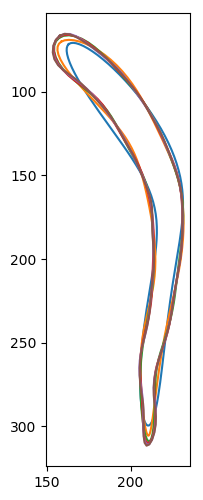

In [28]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
    Fx_cut[cutn:-cutn+1]=0 # 
    Fy_cut[cutn:-cutn+1]=0
    Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
    Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
    Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
    plt.plot(Fx_ifft.real,Fy_ifft.real)

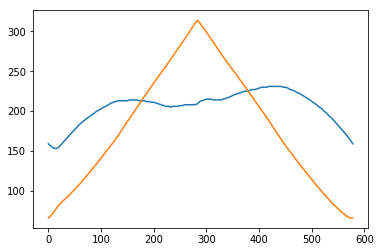

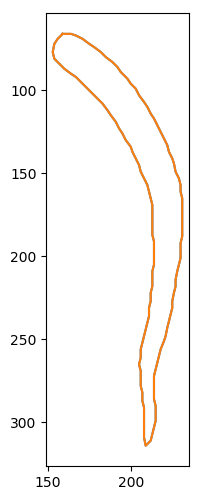

In [29]:
# フーリエ逆変換
Fx_ifft,Fy_ifft = np.fft.ifft(Fx), np.fft.ifft(Fy)
Fx_ifft_real,Fy_ifft_real  = Fx_ifft.real, Fy_ifft.real
plt.plot([lengs[i] for i in s_indexies],Fx_ifft_real)
plt.plot([lengs[i] for i in s_indexies],Fy_ifft_real)
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(Fx_ifft_real,Fy_ifft_real)
plt.plot(Fx_ifft.real,Fy_ifft.real)

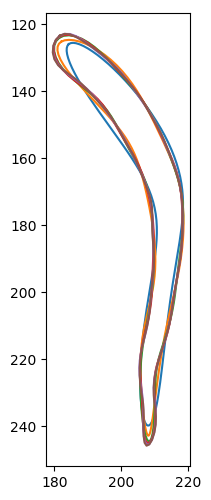

In [30]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
    Fx_cut[cutn:]=0 # 
    Fy_cut[cutn:]=0
    Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
    Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
    Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
    plt.plot(Fx_ifft.real,Fy_ifft.real)

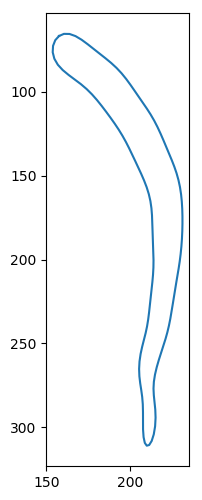

In [31]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(16,17):
    Fx_cut, Fy_cut = Fx.copy(), Fy.copy()
    Fx_cut[cutn:1-cutn]=0 # 
    Fy_cut[cutn:1-cutn]=0
    Fx_ifft,Fy_ifft = np.fft.ifft(Fx_cut), np.fft.ifft(Fy_cut)
    Fx_ifft = np.r_[Fx_ifft,[Fx_ifft[0]]]
    Fy_ifft = np.r_[Fy_ifft,[Fy_ifft[0]]]
    plt.plot(Fx_ifft.real,Fy_ifft.real)

http://www.design.kyushu-u.ac.jp/lib/doctor/1999/k032/k032-03.pdf

http://lbm.ab.a.u-tokyo.ac.jp/~iwata/software/shape_r/shape_r_ppt.pdf